# Case 1 – Support Notes Extraction & Analysis

### Use Jupyter Notebook - Not Google Colab

## Objective

This project enables the Support Operations team at Stratus Edge Software to proactively identify operational bottlenecks, reduce escalations, and improve customer satisfaction by transforming buried freeform notes into structured KPIs.


It transforms raw support notes into analyzable fields like issue type, severity, escalation status, and follow-up needs — enabling data-driven decision-making across support operations.

---

## Dependencies
- `pandas`
- `numpy`
- `openai`
- `matplotlib`, `seaborn`
- `textblob`
- `python-dotenv`
- `tqdm`
- `nltk`
- `openpyxl`

---

##  Workflow Summary

### 1. Load & Clean Data
We import the support notes from CSV, normalize column names, and validate structure. All downstream logic assumes a standardized 'support_note' field as the input for LLM processing.

### 2. LLM Extraction
We use OpenAI’s `gpt-4o-mini` to extract structured insights from each support note. The system prompt ensures consistent fields: issue type, mentioned systems, severity level, resolution status, escalation flag, and follow-up flag. The output is parsed as strict JSON for error-free tabulation.

### 3. Sentiment Analysis
Using TextBlob, we extract polarity scores from each note to gauge emotional tone. This adds interpretability to unresolved or escalated cases and is incorporated into the pain score.

### 4. Validation
Each row is flagged for extraction validity. Sanity checks ensure field distributions are reasonable, and system references are standardized for consistency in grouping.

### 5. Export
Final structured data is saved to `.csv` and `.xlsx` formats for use in dashboards or external BI tools. All processing is modular and reproducible.

---

## Visualizations

Includes business-ready charts for:

- **Problem Children Matrix**  
  Heatmap of the % of High Severity and % Unresolved cases by issue type. This reveals which issue categories need operational focus.

- **Customer Pain Index**  
  Aggregated score across severity, resolution, escalation, follow-up, and sentiment. Systems with highest average pain score are prioritized for engineering or UX review.

- **Sentiment by Resolution Status**  
  Boxplot showing how sentiment correlates with resolution outcomes. Helps understand emotional impact of unresolved or escalated tickets.

- **Recurring Problem Rate**  
  Bar chart showing frequency of recurrence-related keywords per issue type. Useful for identifying areas needing systemic fixes or knowledge base improvements.


---

## Notes

- **Model upgrade**: Used `gpt-4o-mini` to improve severity inference (which was weak in `gpt-3.5-turbo`). The rate of LLM extraction validation (effectively the rate of success of the LLM) was only 83.33% with `gpt-3.5-turbo` and was 100% with `gpt-4o-mini`. That said, the tokens are more expensive, so that will need to be taken into consideration for an actual business.
- **Total token usage** printed at the end for transparency.
- The system is modular and scalable for future extensions (e.g., fallback rules, QA, human-in-the-loop).

---

### Future Work
- Add fallback regex tagging or rule-based backup for extraction failures
- Include human-in-the-loop review interface for edge cases
- Integrate with internal dashboards (e.g., Tableau, Power BI)
- Use embeddings or clustering to auto-discover new issue categories


In [2]:
# Package Import
# !pip install textblob
# !pip install pyarrow
# !pip install python-dotenv

import pandas as pd
import numpy as np
import openai
import os
import re
import json
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from IPython.display import display
from dotenv import load_dotenv
load_dotenv()


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize tokens used
total_tokens_used = 0

# OpenAI key setup
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load support notes
df = pd.read_csv("support_notes.csv")
df.columns = df.columns.str.strip().str.lower()

# Validate expected column
if 'support_note' not in df.columns:
    raise KeyError("Expected column 'support_note' not found in input data.")

df.head()


def build_user_prompt(note_text):
    return f"""
Support Note:
\"\"\"
{note_text.strip()}
\"\"\"

Extract the following fields and return them as a JSON object. Only include values you can confidently infer — if a value is unclear or missing, use null.

- issue_type: A short label for the primary issue (e.g., "login failure", "performance bug", "data sync issue")

- mentioned_systems: List of specific systems, tools, or services referenced (e.g., ["CRM", "auth", "API Gateway"])

- severity: Classify the severity of the issue based on customer impact, urgency, and disruption level. Choose one of ["Low", "Medium", "High"]:
    - "High": Critical issue — major customer disruption, system outage, escalated to Tier 2 or engineering, or strong negative sentiment (e.g., "furious", "angry", "critical")
    - "Medium": Moderate issue — impaired functionality, workaround needed, or delays over 24 hours
    - "Low": Minor issue — cosmetic, informational, quickly resolved, or minimal impact

- resolution_status: One of ["Resolved", "Escalated", "Unresolved"]

- escalation_flag: "Yes" if escalation is mentioned (e.g., sent to Tier 2 or engineering), otherwise "No"

- follow_up_flag: "Yes" if the note indicates more follow-up is needed, otherwise "No"

Example output:
{{
  "issue_type": "login failure",
  "mentioned_systems": ["auth"],
  "severity": "High",
  "resolution_status": "Escalated",
  "escalation_flag": "Yes",
  "follow_up_flag": "Yes"
}}

Return only the JSON object. No explanations.
"""


# LLM Extraction Function
def extract_fields_from_note(note: str, model="gpt-4o-mini") -> dict:
    system_prompt = """
    You are an AI assistant supporting a customer support operations analyst.
    Your task is to extract structured information from unstructured customer support notes.
    Only return a well-formatted JSON object. If a field is not present or unclear, return null.
    """


    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": build_user_prompt(note)}
        ],
        temperature=0.2
    )

    reply = response.choices[0].message.content

    global total_tokens_used

    # Track token usage silently
    if hasattr(response, 'usage') and response.usage is not None:
        total_tokens_used += response.usage.total_tokens
        
    try:
        return json.loads(reply)
    except json.JSONDecodeError:
        print(f"Bad JSON:\n{reply}")
        return {}

# Sentiment Scoring
def get_sentiment_score(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

# Batch Application
tqdm.pandas()

def extract_row(row):
    note = row['support_note']
    
    try:
        result = extract_fields_from_note(note)
    except Exception as e:
        print(f"LLM extraction error: {e}")
        result = {}

    result['sentiment_score'] = get_sentiment_score(note)
    result['llm_extraction_valid'] = int(bool(result.get('issue_type')))
    
    return pd.Series(result)

print("Extracting structured fields and sentiment scores...")
df_structured = df.progress_apply(extract_row, axis=1)
df = pd.concat([df, df_structured], axis=1)

print(f"🧾 Total tokens used across all notes: {total_tokens_used}")

# Sanity Checks
print("=== Value QA Checks ===")
print("Unique values for severity:", df['severity'].unique())
print("Unique values for resolution_status:", df['resolution_status'].unique())
print("Null issue_type rows:", df['issue_type'].isnull().sum())
print("Malformed mentioned_systems entries:")
display(df[~df['mentioned_systems'].apply(lambda x: isinstance(x, list))])

# Save Files
df.to_csv("structured_notes_extended.csv", index=False)
df.to_excel("structured_notes_extended.xlsx", index=False, engine='openpyxl')
print("Structured dataset saved to: structured_notes_extended.csv")
print("Structured dataset saved to: structured_notes_extended.xlsx")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Extracting structured fields and sentiment scores...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]

🧾 Total tokens used across all notes: 48585
=== Value QA Checks ===
Unique values for severity: ['High' 'Medium' 'Low']
Unique values for resolution_status: ['Resolved' 'Unresolved' 'Escalated']
Null issue_type rows: 0
Malformed mentioned_systems entries:


,note_id,support_note,issue_type,mentioned_systems,severity,resolution_status,escalation_flag,follow_up_flag,sentiment_score,llm_extraction_valid
23,24,Duplicate records reported on dashboard. ticke...,data sync issue,None,Medium,Unresolved,No,Yes,-0.050,1
26,27,Data sync issue reported on dashboard. reset u...,data sync issue,None,Low,Resolved,No,No,0.500,1
78,79,Email notifications not sent reported on dashb...,email notification failure,None,Low,Resolved,No,No,0.425,1


Structured dataset saved to: structured_notes_extended.csv


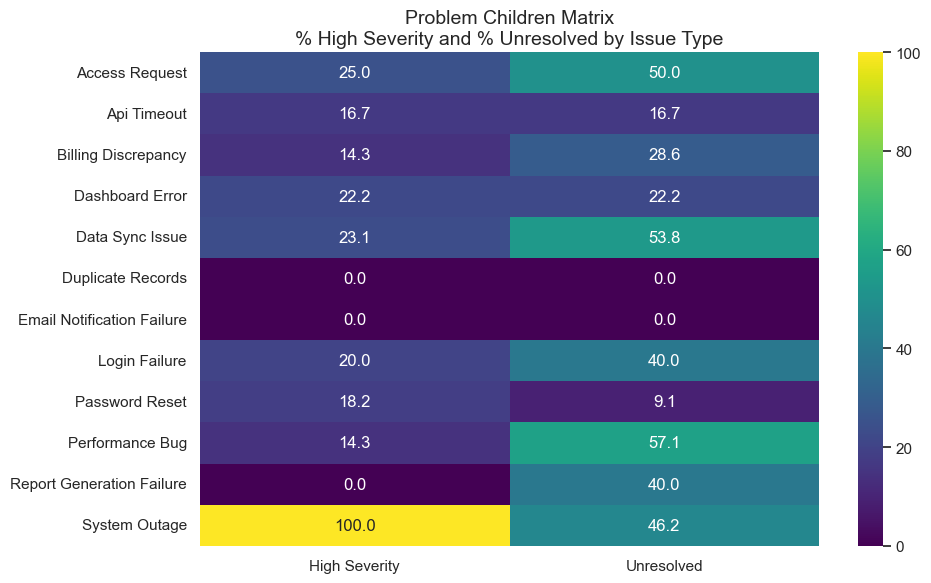

C:\Users\james\AppData\Local\Temp\ipykernel_10752\703981123.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pain_data.values, y=pain_data.index, palette="viridis")


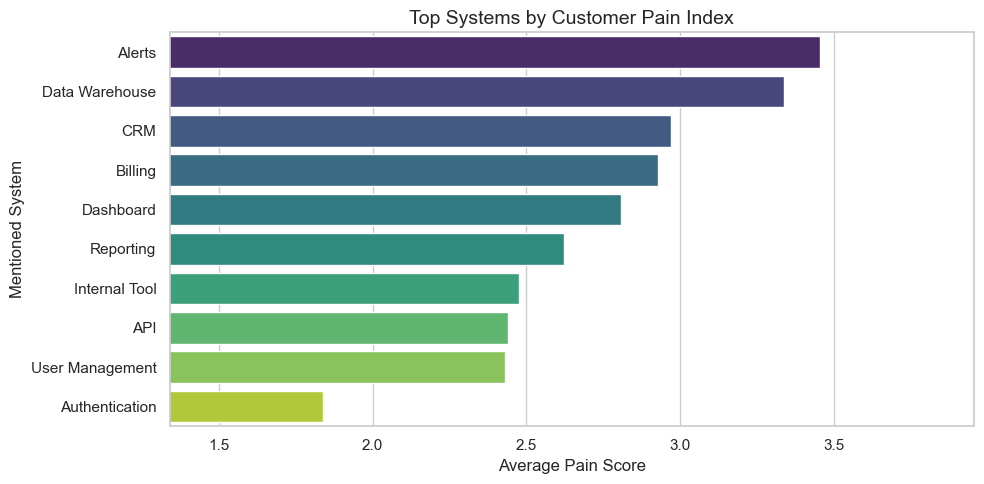

C:\Users\james\AppData\Local\Temp\ipykernel_10752\703981123.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="resolution_status", y="sentiment_score", data=df, palette="viridis")


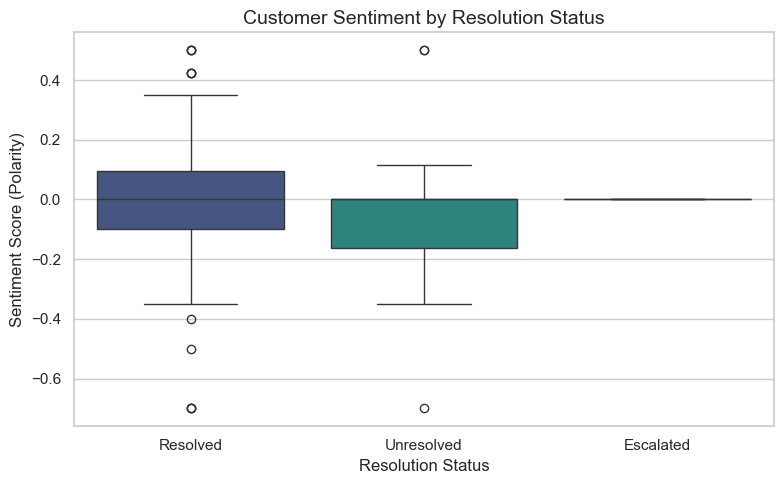

C:\Users\james\AppData\Local\Temp\ipykernel_10752\703981123.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recurring_chart.values, y=recurring_chart.index, palette="viridis")


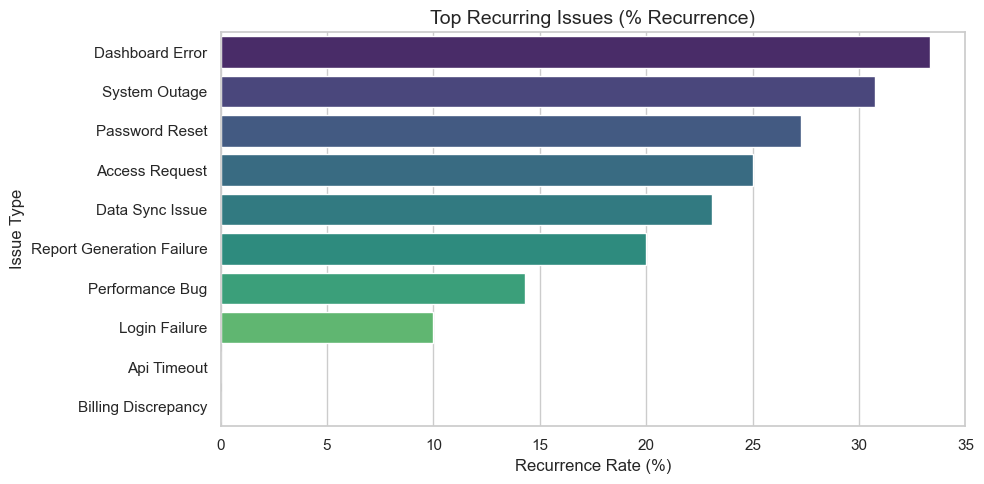

In [29]:
# Normalize severity
df['severity'] = df['severity'].str.strip().str.lower().map({
    'high': 'High',
    'medium': 'Medium',
    'low': 'Low'
})

# Normalize resolution status
df['resolution_status'] = df['resolution_status'].str.strip().str.lower().map({
    'resolved': 'Resolved',
    'unresolved': 'Unresolved',
    'escalated': 'Escalated'
})

# Normalize escalation and follow-up flags
df['escalation_flag'] = df['escalation_flag'].str.strip().str.capitalize()
df['follow_up_flag'] = df['follow_up_flag'].str.strip().str.capitalize()

# Normalize issue_type
df['issue_type'] = df['issue_type'].str.strip().str.lower()
df['issue_type'] = df['issue_type'].replace({
    'api timeout': 'API timeout',
    'api Timeout': 'API timeout',
    'email notification issue': 'Email notification failure',
    'email notifications not sent': 'Email notification failure',
    # Add other standardizations here
})
df['issue_type'] = df['issue_type'].str.title()

# Normalize mentioned systems (list values)
def clean_systems(systems):
    if not isinstance(systems, list):
        return []
    normalized = [s.strip().lower() for s in systems if isinstance(s, str)]
    mapping = {
        'crm': 'CRM',
        'crm system': 'CRM',
        'auth': 'Authentication',
        'authentication service': 'Authentication',
        'dashboard': 'Dashboard',
        'api': 'API',
        'api gateway': 'API',
        'alerts module': 'Alerts',
        'billing system': 'Billing',
        'user management module': 'User Management',
        'data warehouse': 'Data Warehouse',
        'reporting tool': 'Reporting',
    }
    return [mapping.get(s, s.title()) for s in normalized]

df['mentioned_systems'] = df['mentioned_systems'].apply(clean_systems)


sns.set(style="whitegrid", palette="viridis")

# Problem Children Matrix (% High Severity vs. % Unresolved by Issue Type)
df['High Severity'] = df['severity'] == 'High'
df['Unresolved'] = df['resolution_status'] == 'Unresolved'

heatmap_data = (
    df.groupby('issue_type')[['High Severity', 'Unresolved']]
    .mean()
    .reset_index()
    .set_index('issue_type') * 100
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="viridis")
plt.title("Problem Children Matrix\n% High Severity and % Unresolved by Issue Type", fontsize=14)
plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Customer Pain Index by Mentioned System
def compute_pain(row):
    score = 0
    if row['severity'] == 'High':
        score += 2
    elif row['severity'] == 'Medium':
        score += 1
    if row['resolution_status'] == 'Unresolved':
        score += 2
    if row['escalation_flag'] == 'Yes':
        score += 1
    if row.get('follow_up_flag', 'No') == 'Yes':
        score += 1
    if not pd.isna(row['sentiment_score']):
        score += abs(min(row['sentiment_score'], 0)) * 2  # Penalize negative sentiment
    return score

df['pain_score'] = df.apply(compute_pain, axis=1)

pain_data = (
    df.explode('mentioned_systems')
    .groupby('mentioned_systems')['pain_score']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

min_val = max(pain_data.min() - 0.5, 0)

plt.figure(figsize=(10, 5))
sns.barplot(x=pain_data.values, y=pain_data.index, palette="viridis")
plt.title("Top Systems by Customer Pain Index", fontsize=14)
plt.xlabel("Average Pain Score")
plt.ylabel("Mentioned System")
plt.xlim(min_val, pain_data.max() + 0.5)
plt.tight_layout()
plt.show()

# Sentiment Recovery by Resolution Status
plt.figure(figsize=(8, 5))
sns.boxplot(x="resolution_status", y="sentiment_score", data=df, palette="viridis")
plt.title("Customer Sentiment by Resolution Status", fontsize=14)
plt.xlabel("Resolution Status")
plt.ylabel("Sentiment Score (Polarity)")
plt.tight_layout()
plt.show()

# Recurring Problem Rate by Issue Type
recurring_keywords = ['recurring', 'again', 'ongoing', 'repeat', 'repeated']
df['recurring_flag'] = df['support_note'].str.contains('|'.join(recurring_keywords), case=False, na=False)

recurring_chart = (
    df.groupby('issue_type')['recurring_flag']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    * 100
)

plt.figure(figsize=(10, 5))
sns.barplot(x=recurring_chart.values, y=recurring_chart.index, palette="viridis")
plt.title("Top Recurring Issues (% Recurrence)", fontsize=14)
plt.xlabel("Recurrence Rate (%)")
plt.ylabel("Issue Type")
plt.tight_layout()
plt.show()
